# V0.1.6 - Simulate a Predefined Model

Example created by Wilson Rocha Lacerda Junior

In [ ]:
pip install sysidentpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data
from sysidentpy.polynomial_basis.simulation import SimulatePolynomialNarmax


## Generating 1 input 1 output sample data  
### The data is generated by simulating the following model:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-2} + e_{k}$

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma=0.1$

In the next example we will generate a data with 1000 samples with white noise and selecting 90% of the data to train the model. 

In [2]:
x_train, x_test, y_train, y_test = get_siso_data(n=1000,
                                                 colored_noise=False,
                                                 sigma=0.001,
                                                 train_percentage=90)

## Defining the model

We already know that the generated data is a result of the model  $ùë¶_ùëò=0.2ùë¶_{ùëò‚àí1}+0.1ùë¶_{ùëò‚àí1}ùë•_{ùëò‚àí1}+0.9ùë•_{ùëò‚àí2}+ùëí_ùëò$ . Thus, we can create a model with those regressors follwing a codification pattern:
- $0$ is the constant term,
- $[1001] = y_{k-1}$
- $[100n] = y_{k-n}$
- $[200n] = x1_{k-n}$
- $[300n] = x2_{k-n}$
- $[1011, 1001] = y_{k-11} \times y_{k-1}$
- $[100n, 100m] = y_{k-n} \times y_{k-m}$
- $[12001, 1003, 1001] = x11_{k-1} \times y_{k-3} \times y_{k-1}$
- and so on

### Importante Note

The order of the arrays matter. 

If you use [2001, 1001], it will work, but [1001, 2001] will not (the regressor will be ignored). Always put the highest value first:
- $[2003, 2001]$ **works**
- $[2001, 2003]$ **do not work**

We will handle this limitation in upcoming update.

In [3]:
s = SimulatePolynomialNarmax()

# the model must be a numpy array
model = np.array(
    [
    [1001,    0], # y(k-1)
    [2001, 1001], # x1(k-1)y(k-1)
    [2002,    0], # x1(k-2)
    ]
                )
# theta must be a numpy array of shape (n, 1) where n is the number of regressors
theta = np.array([[0.2, 0.9, 0.1]]).T

## Simulating the model

After defining the model and theta we just need to use the simulate method.

The simulate method returns the predicted values and the results where we can look at regressors,
parameters and ERR values.

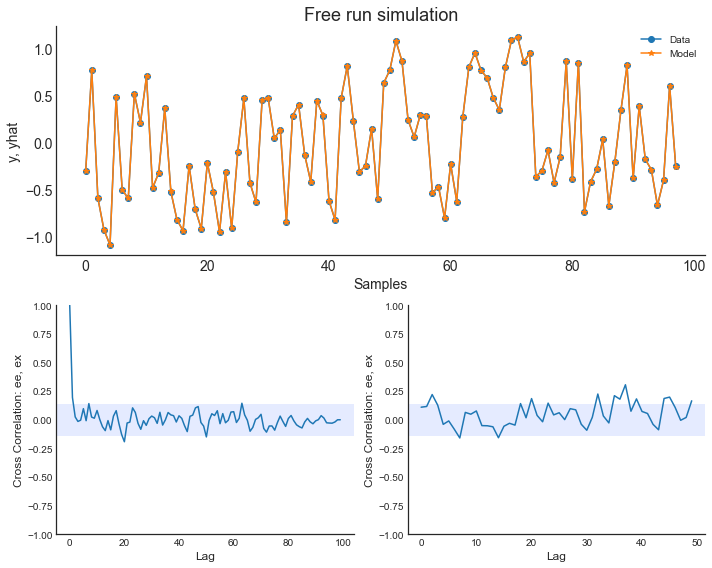

In [4]:
yhat, results = s.simulate(
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    theta=theta,
    plot=True)

In [5]:
results = pd.DataFrame(results, columns=['Regressors', 'Parameters', 'ERR'])
results

Regressors Parameters         ERR
0         y(k-1)     0.2000  0.00000000
1        x1(k-2)     0.9000  0.00000000
2  x1(k-1)y(k-1)     0.1000  0.00000000

### Options

You can set the `steps_ahead` to run the prediction/simulation:

In [6]:
yhat, results = s.simulate(
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    theta=theta,
    plot=False,
    steps_ahead=1)
rrse = root_relative_squared_error(y_test, yhat)
rrse

0.001695176840746673

In [7]:
yhat, results = s.simulate(
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    theta=theta,
    plot=False,
    steps_ahead=21)
rrse = root_relative_squared_error(y_test, yhat)
rrse

0.0017301972652496206

### Estimating the parameters

If you have only the model strucuture, you can create an object with `estimate_parameter=True` and
choose the methed for estimation using `estimator`. In this case, you have to pass the training data
for parameters estimation. 

When `estimate_parameter=True`, we also computate the ERR considering only the regressors defined by the user. 

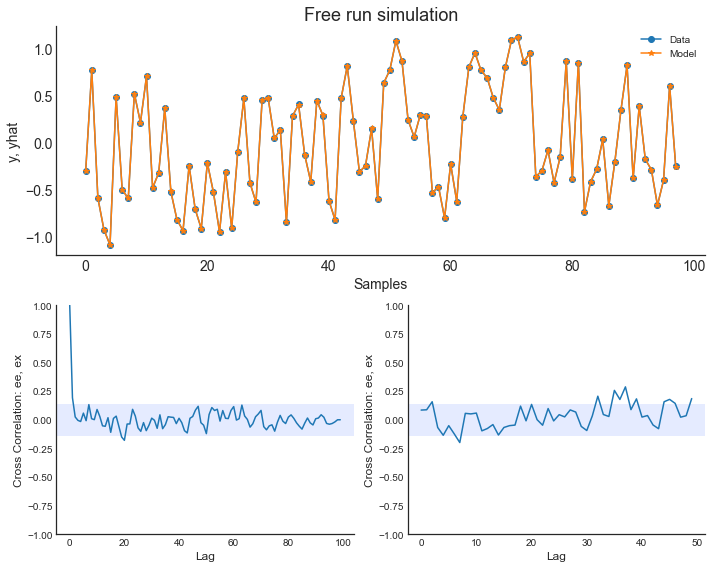

Regressors Parameters         ERR
0         y(k-1)     0.2003  0.95597023
1        x1(k-2)     0.9000  0.04072471
2  x1(k-1)y(k-1)     0.1002  0.00330137

In [8]:
s2 = SimulatePolynomialNarmax(estimate_parameter=True, estimator='recursive_least_squares')
yhat, results = s2.simulate(
    X_train=x_train,
    y_train=y_train,
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    # theta will be estimated using the defined estimator
    plot=True)

results = pd.DataFrame(results, columns=['Regressors', 'Parameters', 'ERR'])
results

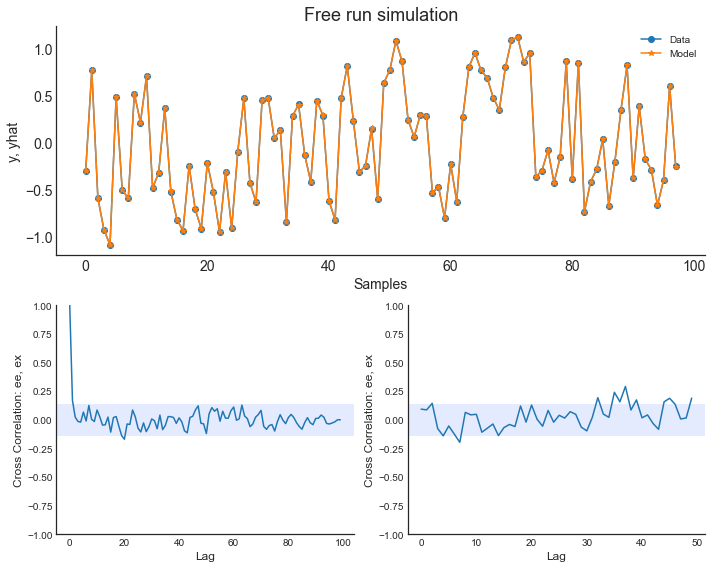

Regressors Parameters         ERR
0         y(k-1)     0.2003  0.95597023
1        x1(k-2)     0.9000  0.04072471
2  x1(k-1)y(k-1)     0.1002  0.00330137

In [9]:
yhat, results = s2.simulate(
    X_train=x_train,
    y_train=y_train,
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    # theta will be estimated using the defined estimator
    plot=True,
    steps_ahead=8)

results = pd.DataFrame(results, columns=['Regressors', 'Parameters', 'ERR'])
results

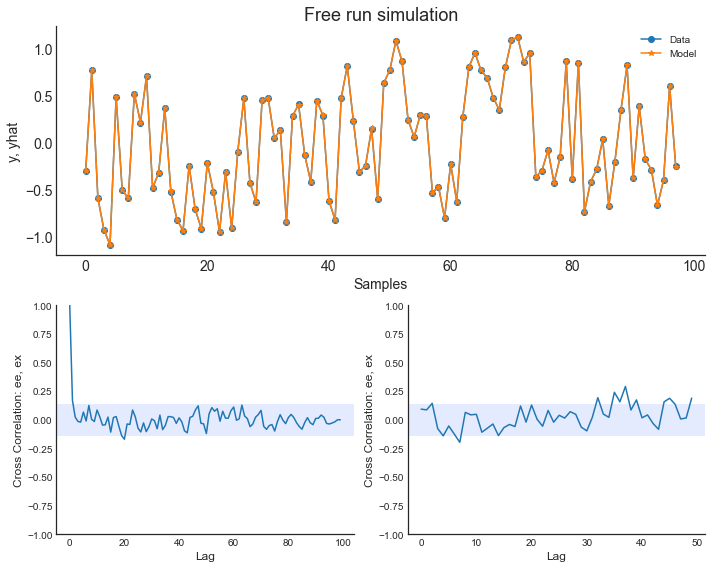

In [10]:
yhat, results = s2.simulate(
    X_train=x_train,
    y_train=y_train,
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    # theta will be estimated using the defined estimator
    plot=True,
    steps_ahead=8)
